# Statistical Inference and EDA of BTC/ETH prices and GoogleNews search frequency of the word "cryptocurrency"

Due to volatility of crytocurrency market, one might wonder what is the best way to predict the currencies prices. As I came up with the project idea, the preliminary questions I had in mind were:

1.Is there any obvious correlation/lead-lag relationship between different crytocurrency market prices?

2.If the correlation between a pair of currencies A and B existed, can we use currency A price history to predict future price of currency B? Will it be more useful than using just historical prices of currency B alone?

3.Does the rise/fall in search frequency of the word "crytocurrency" on GoogleNews imply trading signal?

The following code queries, visualizes, and tests data in order to explore the preliminary questions. The stretch goal is to gain insights beyond preliminary questions that will lead to better data analysis in the future

In [1]:
# Can we get more data ? 
# Getting price data of BTC and ETH using Cryptocompare API
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime

# Indicate how many rows of data here
lim = '15000' 
story_coin = ['BTC', 'ETH']
story_data = pd.DataFrame()
for i in story_coin:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index ,unit='s')
    story_data = pd.concat([story_data, table.high], axis=1)
story_data.columns = story_coin
print(story_data.head())
print(story_data.tail())
from_date = story_data.index[0].strftime('%Y-%m-%d') # Get date where the query started
to_date = story_data.index[-1].strftime('%Y-%m-%d') # Get date where the query ended

                         BTC     ETH
time                                
2018-04-05 21:00:00  6772.78  378.21
2018-04-05 22:00:00  6855.56  384.56
2018-04-05 23:00:00  6861.83  385.54
2018-04-06 00:00:00  6862.94  385.78
2018-04-06 01:00:00  6845.07  384.73
                         BTC     ETH
time                                
2018-06-28 01:00:00  6159.44  442.36
2018-06-28 02:00:00  6159.20  438.98
2018-06-28 03:00:00  6143.94  437.64
2018-06-28 04:00:00  6124.63  432.75
2018-06-28 05:00:00  6116.29  431.98


In [4]:
# Getting data from Google Trends using Pytrends API

from pytrends.request import TrendReq
# Login to Google. Only need to run this once
pytrend = TrendReq()
# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe='2018-04-05 2018-06-28')  

story_ggtrends = pytrend.interest_over_time()
# Upsampling daily data to hourly data
story_ggtrends = story_ggtrends.resample('1h').pad().drop(['isPartial'], axis='columns')
story_ggtrends.columns = ['SearchFrequency']

In [5]:
# Joining two data frames

story_combined = pd.concat([story_data, story_ggtrends], axis=1).dropna(how='any')
story_combined_scaled = story_combined.copy(deep=True)
story_combined_scaled .head()

,BTC,ETH,SearchFrequency
time,,,
2018-04-05 21:00:00,6772.78,378.21,76.0
2018-04-05 22:00:00,6855.56,384.56,76.0
2018-04-05 23:00:00,6861.83,385.54,76.0
2018-04-06 00:00:00,6862.94,385.78,64.0
2018-04-06 01:00:00,6845.07,384.73,64.0


In [6]:
# Scaling everything to get a beter sense of relationship 
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
story_combined_scaled['BTC'] = sc_x.fit_transform(story_combined_scaled['BTC'].values.reshape(-1,1))
story_combined_scaled['ETH'] = sc_x.fit_transform(story_combined_scaled['ETH'].values.reshape(-1,1))
story_combined_scaled['SearchFrequency'] = sc_x.fit_transform(story_combined_scaled['SearchFrequency'].values.reshape(-1,1))

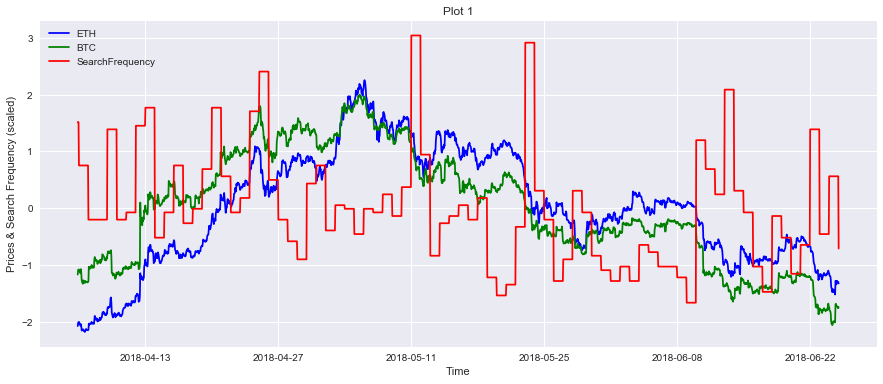

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 1')
plt.rcParams["figure.figsize"] = (17,6)
plt.show()

From plot 1, I noticed that the spike in search frequency associated with a large drop in the price of BTC and ETH. While there is no significant spike in search frequency when the price of BTC and ETH was claiming. 

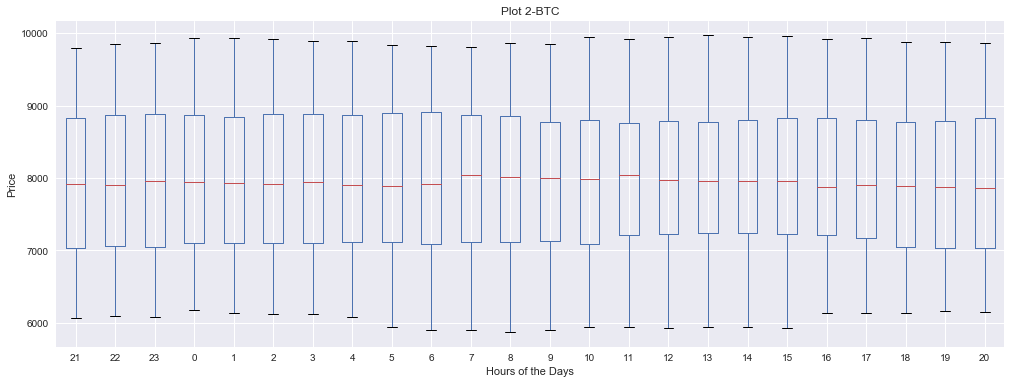

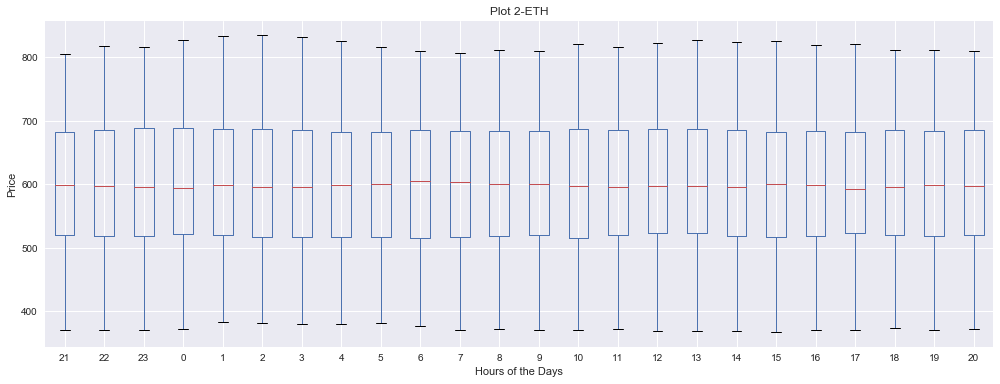

In [24]:
# Plot 2- Box plot by hour of the day

from datetime import datetime, timezone
from collections import OrderedDict
from collections import defaultdict

for coin in story_coin:
    group = OrderedDict.fromkeys(story_combined[coin].index.hour)
    group = defaultdict(list)
    for i in story_combined[coin].index:
        group[i.hour].append(story_combined[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    hour = pd.DataFrame()
    for key, value in group.items():
        hour[key] = value[:min_len]
    hour.boxplot()
    plt.ylabel('Price')
    plt.xlabel('Hours of the Days')
    plt.title('Plot 2-{}'.format(coin), loc='center')
    plt.show()

As we can see from plot 2, the mean and variance are constant through the hour of the day. It means that the price of 
BTC and ETH have no seasonality though treading hour. 

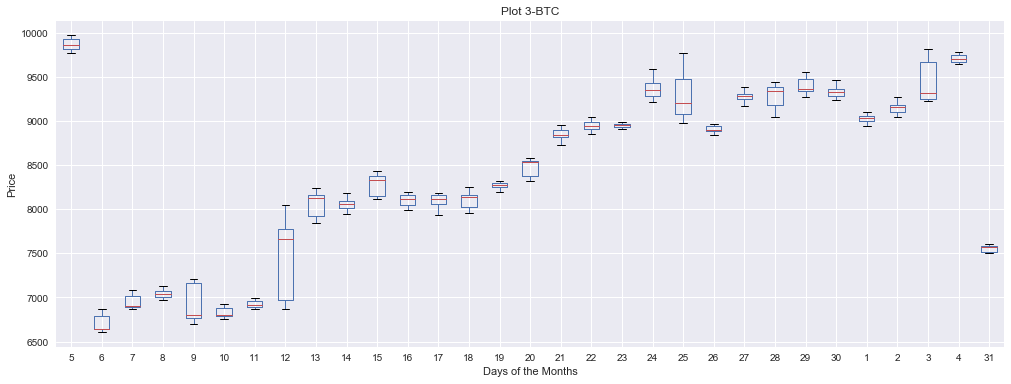

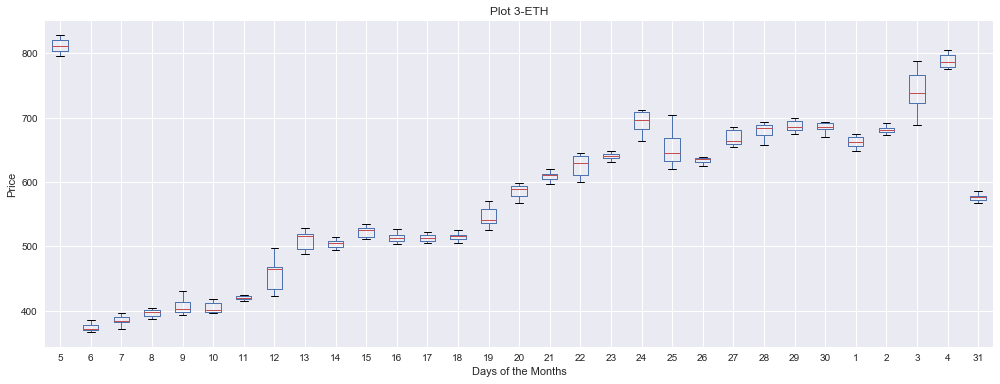

In [25]:
# Plot 3- Box plot by day of the month

for coin in story_coin:    
    group = OrderedDict.fromkeys(story_combined[coin].index.day)
    group = defaultdict(list)
    for i in story_combined[coin].index:
        group[i.day].append(story_combined[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    day = pd.DataFrame()
    for key, value in group.items():
        day[key] = value[:min_len]
    

    day.boxplot()
    plt.ylabel('Price')
    plt.xlabel('Days of the Months')
    plt.title('Plot 3-{}'.format(coin), loc='center')
    plt.show()

As we can see from plot 3, the mean and variance are various from days of the month. This can be interpreted that the
price of BTC and ETH is related to days of the month. However, I believe that this pattern is due to a small sample. 
We need more data to investigate this phenomenon 

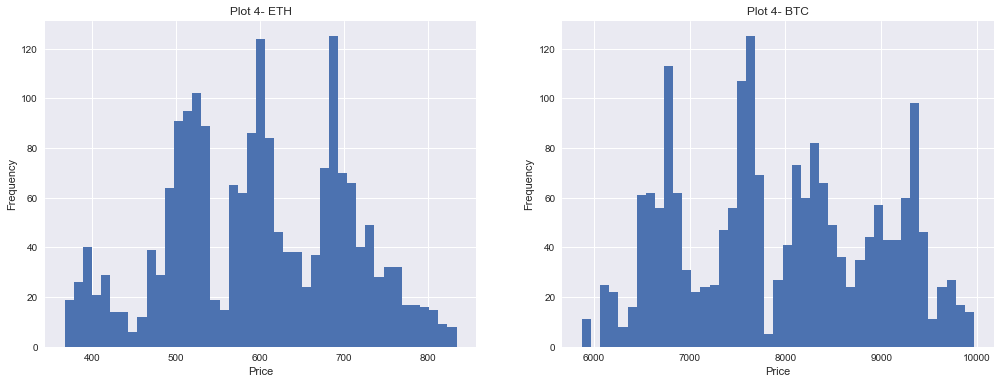

In [28]:
# Plot 4- BTC/ETH histogram

n_data = len(story_combined['ETH'])
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
story_combined['ETH'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 4- ETH', loc='center')
plt.subplot(1, 2, 2)
story_combined['BTC'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 4- BTC', loc='center')
plt.show()

Plot 4 shows that the price of BTC and ETH is not normally distributed. 
Also, ETH price has a wider range of moving compared to BTC price.  

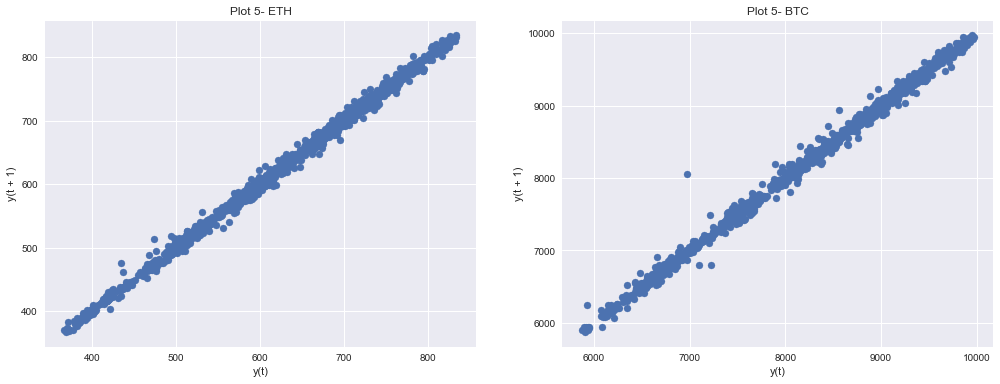

In [29]:
# Plot 5- BTC/ETH lag1 scatter plot

from pandas.plotting import lag_plot
plt.subplot(1, 2, 1)
lag_plot(story_combined['ETH'])
plt.title('Plot 5- ETH', loc='center')
plt.subplot(1, 2, 2)
lag_plot(story_combined['BTC'])
plt.title('Plot 5- BTC', loc='center')
plt.show()

Obviously, the first lag of the price itself is highly correlated to present price in both ETH and BTC. 

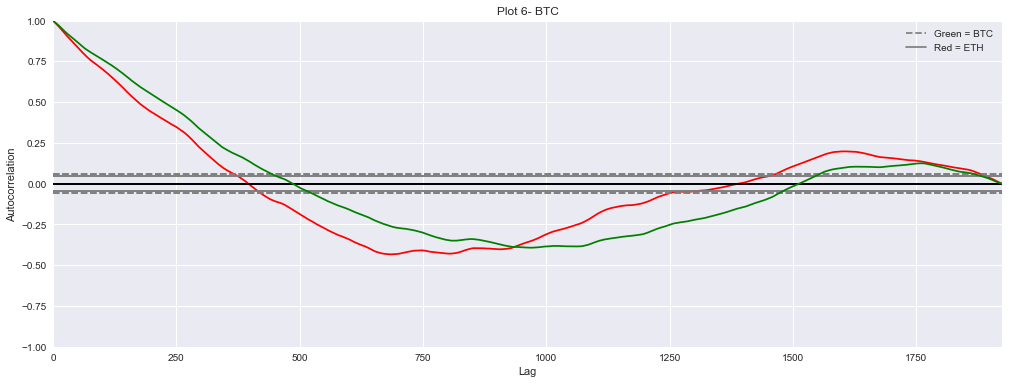

In [56]:
# Plot 6- BTC/ETH autocorrelation plot

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(story_combined['ETH'],color = 'red')
plt.title('Plot 6- ETH', loc='center')
autocorrelation_plot(story_combined['BTC'], color = 'green')
plt.title('Plot 6- BTC', loc='center')
plt.legend(['Green = BTC','Red = ETH'])
plt.show()

The relationship between lag-n and present price is decreasing over time.  

### Next, we will try to run some time series test on price

In [57]:
# Result 1- Perform Dickey Fuller Test to determine stationality of BTC and ETC time series

from statsmodels.tsa.stattools import adfuller
x = story_combined['ETH'].values
DF_ETH = adfuller(x)
print('\n')
print('\033[1m' + 'Result 1' + '\033[0m')
print('ADF Statistic (ETH): %f' % DF_ETH[0])
print('p-value: %f' % DF_ETH[1])
print('Critical Values:')
for key, value in DF_ETH[4].items():
    print('\t%s: %.3f' % (key, value))

y = story_combined['BTC'].values
DF_BTC = adfuller(y)
print('\n')
print('ADF Statistic (BTC): %f' % DF_BTC[0])
print('p-value: %f' % DF_BTC[1])
print('Critical Values:')
for key, value in DF_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools




Result 1
ADF Statistic (ETH): -1.694046
p-value: 0.434183
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (BTC): -0.854081
p-value: 0.802718
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568




From Result 1 above, Dickey-Fuller test shows that both ETH and BTC are NOT stationary series(P-value is higher than 0.05). 
To stationarize the series, we're going to perform differencing. There are combinations of lag difference and difference order we could pick from. 
First, we're going to take the difference using lag 1 order 1 on both series.

In [61]:
# create a differenced series, with default value of lag 1
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# difference the dataset
diff_BTC = difference(story_combined['BTC'])
diff_ETH = difference(story_combined['ETH'])

diff_ETH_2 = difference(story_combined['ETH'], 2)
diff_ETH_24 = difference(story_combined['ETH'], 24)
diff_BTC_2 = difference(story_combined['BTC'], 2)
diff_BTC_24 = difference(story_combined['BTC'], 24)

We made 3 differenced series 1 lag, 2 lag, and 24 lag in order to see whether the result of ADF will vary among each series

In [64]:
DF_diff_BTC = adfuller(diff_BTC)
print('\n')
print('\033[1m' + 'Result 2' + '\033[0m')
print('ADF Statistic (BTC): %f' % DF_diff_BTC[0])
print('p-value: %f' % DF_diff_BTC[1])
print('Critical Values:')
for key, value in DF_diff_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
DF_diff_ETH = adfuller(diff_ETH)
print('\n')
print('ADF Statistic (ETH): %f' % DF_diff_ETH[0])
print('p-value: %f' % DF_diff_ETH[1])
print('Critical Values:')
for key, value in DF_diff_ETH[4].items():
    print('\t%s: %.3f' % (key, value))


DF_diff_BTC_2 = adfuller(diff_BTC_2)
print('\n')
print('ADF Statistic (BTC): %f' % DF_diff_BTC_2[0])
print('p-value: %f' % DF_diff_BTC[1])
print('Critical Values:')
for key, value in DF_diff_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
DF_diff_ETH_2 = adfuller(diff_ETH_2)
print('\n')
print('p-value: %f' % DF_diff_ETH[1])
print('Critical Values:')
for key, value in DF_diff_ETH[4].items():
    print('\t%s: %.3f' % (key, value))

DF_diff_BTC_24 = adfuller(diff_BTC_24)
print('\n')
print('ADF Statistic (BTC): %f' % DF_diff_BTC_24[0])
print('p-value: %f' % DF_diff_BTC[1])
print('Critical Values:')
for key, value in DF_diff_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
DF_diff_ETH_24 = adfuller(diff_ETH_24)
print('\n')
print('ADF Statistic (ETH): %f' % DF_diff_ETH_24[0])
print('p-value: %f' % DF_diff_ETH[1])
print('Critical Values:')
for key, value in DF_diff_ETH[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')



Result 2
ADF Statistic (BTC): -43.025489
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (ETH): -29.705821
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (BTC): -7.958348
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (BTC): -5.549674
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (ETH): -5.407239
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568




We have stationarize the series. And, there is no difference in lag used to perform differentiating 

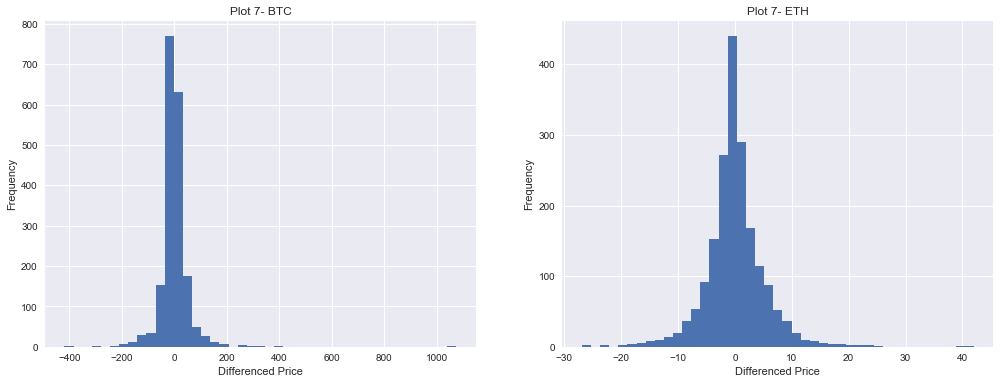

In [69]:
# Plot7- Plotting Histogram of differenced series# Plot8- 

n_data = len(diff_ETH)
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
plt.hist(diff_BTC, bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Differenced Price')
plt.title('Plot 7- BTC', loc='center')
plt.subplot(1, 2, 2)
plt.hist(diff_ETH, bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Differenced Price')
plt.title('Plot 7- ETH', loc='center')
plt.show()

Histogram of the difference, Plot 6, shows that the distribution normally distributed. We can use this series to apply the model 


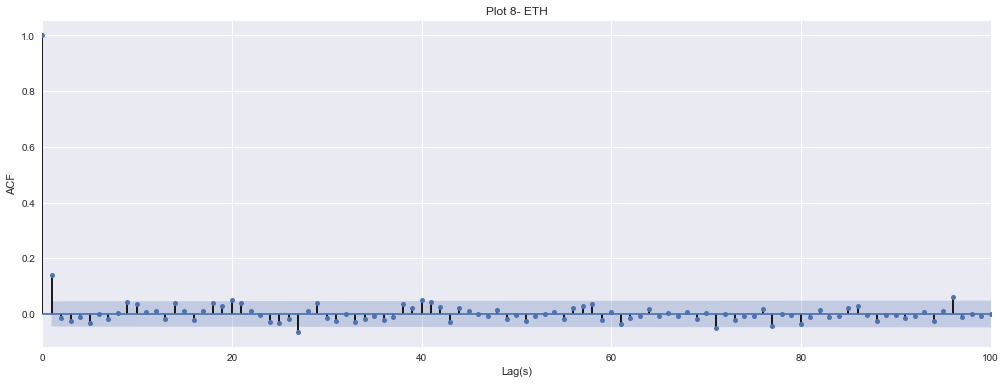

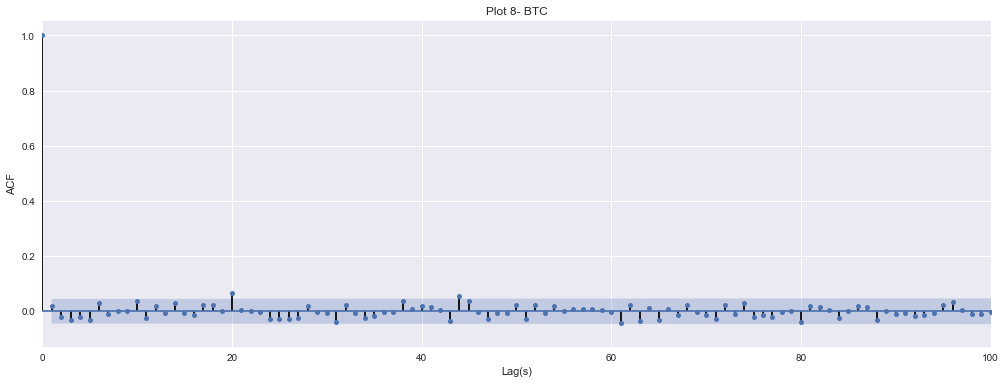

In [70]:
# Plot 8- ACF plot of the differenced series using lag 1 order 1
from statsmodels.graphics.tsaplots import plot_acf
from pandas import tseries
plot_acf(diff_ETH)
plt.title('Plot 8- ETH', loc='center')
plt.xlim((0, 100))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plot_acf(diff_BTC)
plt.title('Plot 8- BTC', loc='center')
plt.xlim((0, 100))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.show()

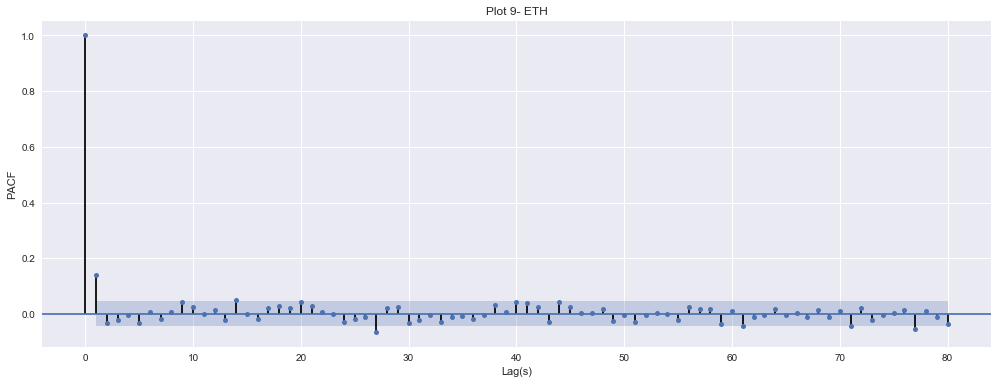

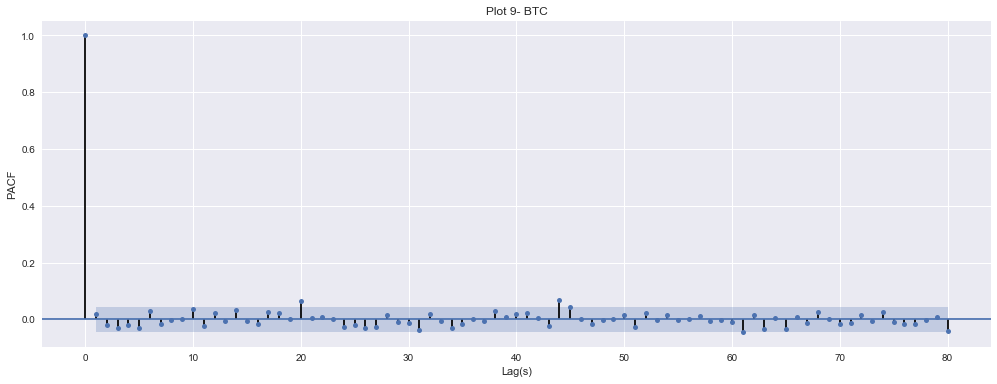

In [71]:
# Plot 9- PACF plot of the differenced series using lag 1 order 1

from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(diff_ETH, lags=80)
plt.title('Plot 9- ETH', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')

plot_pacf(diff_BTC, lags=80)
plt.title('Plot 9- BTC', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')
plt.show()

From plots 8-9, pacf and acf do not tell us much about the model we are going to use. We will discuss more about this later. 



ADF Statistic: -7.720816
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


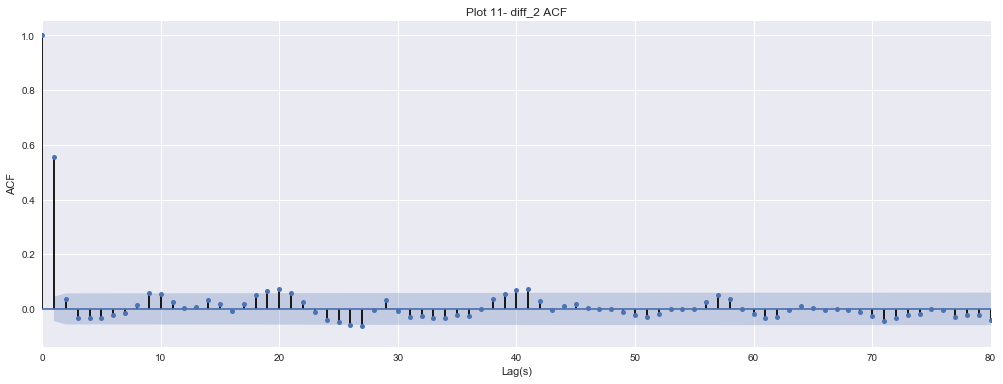

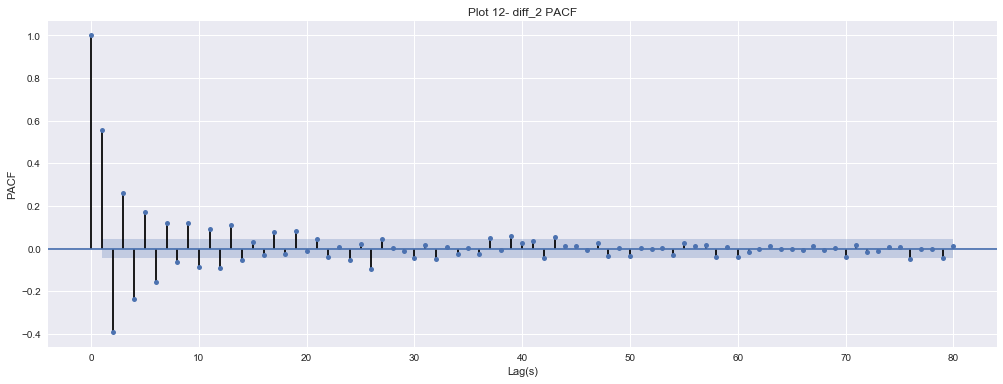

In [75]:
# Dickey Fuller Test result, ACF, and PACF plots of differenced series using lag 2 order 1# Dickey 

DF_diff_2 = adfuller(diff_2)
print('\n')
print('ADF Statistic: %f' % DF_diff_2[0])
print('p-value: %f' % DF_diff_2[1])
print('Critical Values:')
for key, value in DF_diff_2[4].items():
    print('\t%s: %.3f' % (key, value))
    
plot_acf(diff_2)
plt.title('Plot 11- diff_2 ACF', loc='center')
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.xlim([0, 80])
plt.show()

plot_pacf(diff_2, lags=80)
plt.title('Plot 12- diff_2 PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')    
plt.show()



ADF Statistic: -5.407239
p-value: 0.000003
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


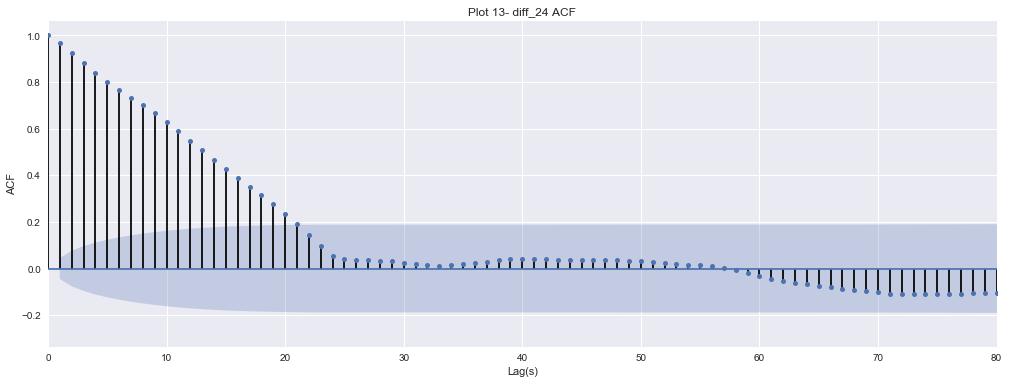

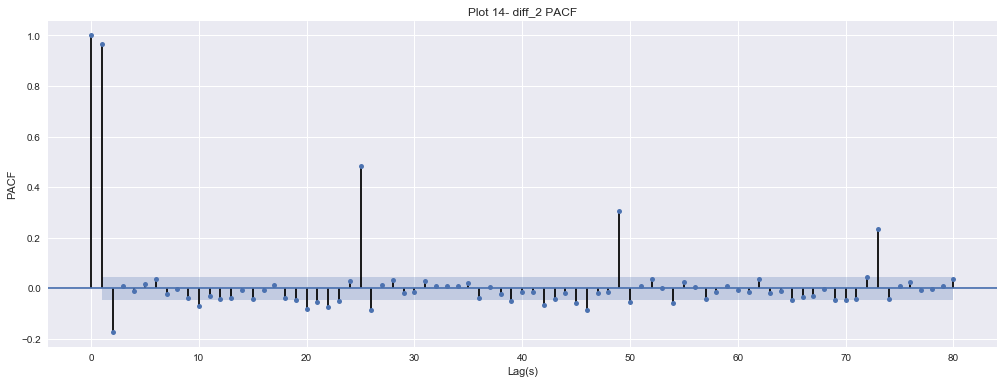

In [74]:
# Dickey Fuller Test result, ACF, and PACF plots of differenced series using lag 2 order 1

DF_diff_24 = adfuller(diff_24)
print('\n')
print('ADF Statistic: %f' % DF_diff_24[0])
print('p-value: %f' % DF_diff_24[1])
print('Critical Values:')
for key, value in DF_diff_24[4].items():
    print('\t%s: %.3f' % (key, value))
    
plot_acf(diff_24)
plt.title('Plot 13- diff_24 ACF', loc='center')
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.xlim([0, 80])
plt.show()

plot_pacf(diff_24, lags=80)
plt.title('Plot 14- diff_2 PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')    
plt.show()

Conclusion:
    
-There seem to be high correlation between the rise in search frequency and the drop in currencies prices

-High correlation between BTC and ETH

-There is a high correlation between an observation and it's lag 1 (x_t and x_t-1)

-Both series have no obvious trends or seasonalities


# Getting Data

The following code query and clean the following data: 

1) Top eight cryptocurrency

2) Google News search frequency for the phrase "cryptocurrency"- This data should capture turning point events that affect the crytocurrency markets.

4) Google search frequency for the phrases “Nem wallet download”, “Iota wallet download”, “Nem price”, “Iota price”, “Bitcoin price"- This data should reflect the demand.

5) AMD and Nvidia stock prices- The top 2 semiconductor companies used for coin mining.

6) Google search frequency for the phrase “GPU for mining”- I expect this data to capture the increased demand for coin mining.

In [82]:
import cryptocompare
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime
from pytrends.request import TrendReq
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader
import demjson
import eventregistry
import fix_yahoo_finance as yf


# Login to Google
pytrend = TrendReq()
# Get today date
today_date = datetime.datetime.now().strftime('%Y-%m-%d')

In [83]:
# Getting price data of XEM and IOT using Cryptocompare API# Getti 

# Indicate how many rows of data here
lim = '18000' 
pair = ['BTC', 'ETH','EOS','BCH','ETC','LTC','TRX','QTUM']
coins = pd.DataFrame()
# Making API call, normalize JSON file, and put it in Dataframe
for i in pair:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim 
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time') # Set index
    table.index = pd.to_datetime(table.index ,unit='s') # Make datetime object
    coins = pd.concat([coins, table.high], axis=1)
coins.columns = pair

from_date = coins.index[0].strftime('%Y-%m-%d') # Get date where the query started
to_date = coins.index[-1].strftime('%Y-%m-%d') # Get date where the query ended

In [84]:
print(from_date, to_date)

2018-04-05 2018-06-28


In [85]:
# Query stock data from Morning Star using pandas_datareader

# Specify start and end time here
start = from_date
end = to_date

amd = pandas_datareader.mstar.daily.MorningstarDailyReader('AMD',start= start,end= end)
nvda = pandas_datareader.mstar.daily.MorningstarDailyReader('nvda',start= start,end= end)

# Cleaning and resampling data
amd = amd.read().reset_index(level='Symbol').resample('1h').pad().drop(['Open', 'Low', 'High', 'Symbol', 'Volume'], axis='columns')
nvda = nvda.read().reset_index(level='Symbol').resample('1h').pad().drop(['Open', 'Low', 'High', 'Symbol', 'Volume'], axis='columns')
amd.columns = ['amd']
nvda.columns = ['nvda']
print(amd.head(), nvda.head())

                       amd
Date                      
2018-04-05 00:00:00  10.02
2018-04-05 01:00:00  10.02
2018-04-05 02:00:00  10.02
2018-04-05 03:00:00  10.02
2018-04-05 04:00:00  10.02                        nvda
Date                       
2018-04-05 00:00:00  221.38
2018-04-05 01:00:00  221.38
2018-04-05 02:00:00  221.38
2018-04-05 03:00:00  221.38
2018-04-05 04:00:00  221.38


In [86]:
# Getting data from Google Trends using Pytrends API
 
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe=from_date+' '+today_date) # Build payload
ggtrends_1 = pytrend.interest_over_time()
ggtrends_1 = ggtrends_1.resample('1h').pad().drop(['isPartial'], axis='columns') # Upsample daily to hourly
ggtrends_1.columns = ['gg_crypto']

# keyword = 'nem price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['nem price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_2 = pytrend.interest_over_time()
ggtrends_2 = ggtrends_2.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_2.columns = ['gg_nem_p']

# keyword = 'iota price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['iot price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_3 = pytrend.interest_over_time()
ggtrends_3 = ggtrends_3.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_3.columns = ['gg_iota_p']

# keyword = 'bitcoin price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['bitcoin price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_4 = pytrend.interest_over_time()
ggtrends_4 = ggtrends_4.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_4.columns = ['gg_bitcoin_p']

# keyword = 'nem wallet', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['nem wallet'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_5 = pytrend.interest_over_time()
ggtrends_5 = ggtrends_5.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_5.columns = ['gg_nem_w']

# keyword = 'iota wallet', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['iota wallet'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_6 = pytrend.interest_over_time()
ggtrends_6 = ggtrends_6.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_6.columns = ['gg_iota_w']

# keyword = 'gpu mining', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['gpu mining'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_7 = pytrend.interest_over_time()
ggtrends_7 = ggtrends_7.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_7.columns = ['gg_gpu']

In [87]:
# Joining data frames
df = pd.concat([coins, amd, nvda, ggtrends_1, ggtrends_2, ggtrends_3, ggtrends_4, ggtrends_5, ggtrends_6, ggtrends_7], axis=1).dropna(how='any')
df.to_csv('cap1_df.csv')
print(df.head())

                         BTC     ETH   EOS     BCH    ETC     LTC      TRX  \
time                                                                         
2018-04-05 22:00:00  6855.56  384.56  6.41  648.10  13.80  119.99  0.03930   
2018-04-05 23:00:00  6861.83  385.54  6.41  649.50  13.84  120.25  0.04026   
2018-04-06 00:00:00  6862.94  385.78  6.38  648.76  13.83  120.47  0.04036   
2018-04-06 01:00:00  6845.07  384.73  6.24  647.68  13.82  119.68  0.04120   
2018-04-06 02:00:00  6840.40  381.60  6.18  646.24  13.75  119.26  0.04125   

                      QTUM    amd    nvda  gg_crypto  gg_nem_p  gg_iota_p  \
time                                                                        
2018-04-05 22:00:00  13.38  10.02  221.38       76.0      17.0       51.0   
2018-04-05 23:00:00  13.55  10.02  221.38       76.0      17.0       51.0   
2018-04-06 00:00:00  13.50   9.61  214.25       64.0      35.0       70.0   
2018-04-06 01:00:00  13.46   9.61  214.25       64.0      35.0      

In [88]:
df_scaled = df.copy(deep=True)

sc_x = StandardScaler()
df_scaled = pd.DataFrame(sc_x.fit_transform(df), index=df.index, columns=df.columns)

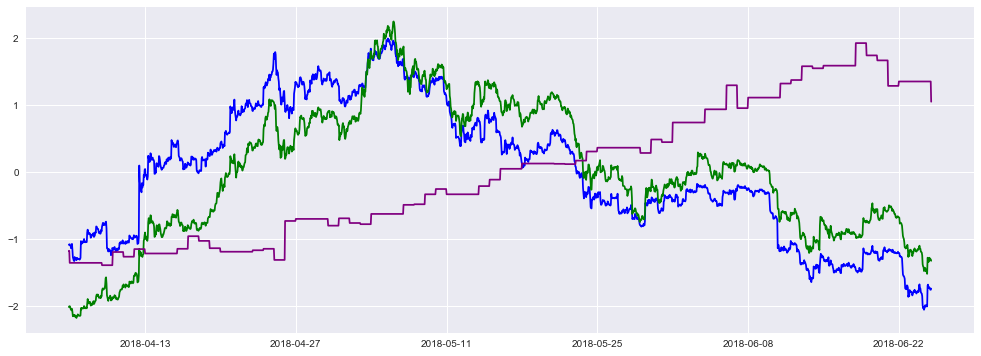

In [89]:
plt.plot(df_scaled.index, df_scaled['BTC'], color='blue')
plt.plot(df_scaled.index, df_scaled['ETH'], color='green')
#plt.plot(df_scaled.index, df_scaled['mc_nem'], color='blue')
#plt.plot(df_scaled.index, df_scaled['mc_iota'], color='blue')
#plt.plot(df_scaled.index, df_scaled['gg_crypto'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_nem_p'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_iota_p'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_bitcoin_p'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_iota_w'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_nem_w'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_gpu'], color='yellow')
plt.plot(df_scaled.index, df_scaled['amd'], color='purple')
#plt.plot(df_scaled.index, df_scaled['nvda'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['rd_CrypCurr_g'], color='blue')
#plt.plot(df_scaled.index, df_scaled['rd_nem_g'], color='blue')
#plt.plot(df_scaled.index, df_scaled['rd_Iota_g'], color='blue')
#plt.xlim(('2017-11-01', '2017-10-10'))
plt.show()

In [90]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

In [91]:
# Standardize the data
df = pd.read_csv('cap1_df.csv', index_col='time')
sc_x = StandardScaler()
df_scaled_1 = pd.DataFrame(sc_x.fit_transform(df), index=df.index, columns=df.columns)
df_scaled_1.head()

,BTC,ETH,EOS,BCH,ETC,LTC,TRX,QTUM,amd,nvda,gg_crypto,gg_nem_p,gg_iota_p,gg_bitcoin_p,gg_nem_w,gg_iota_w,gg_gpu
time,,,,,,,,,,,,,,,,,
2018-04-05 22:00:00,-1.087640,-2.017753,-1.733043,-1.550200,-1.164221,-0.418166,-1.323768,-0.592456,-1.178310,-1.517781,1.515110,-0.507141,0.681538,2.561620,-0.833025,0.655048,-0.059743
2018-04-05 23:00:00,-1.081427,-2.008447,-1.733043,-1.545437,-1.150691,-0.406196,-1.264898,-0.549549,-1.178310,-1.517781,1.515110,-0.507141,0.681538,2.561620,-0.833025,0.655048,-0.059743
2018-04-06 00:00:00,-1.080327,-2.006168,-1.741500,-1.547955,-1.154074,-0.396067,-1.258766,-0.562168,-1.358016,-1.985374,0.752183,0.171177,1.462562,2.917154,-0.833025,-0.622383,1.484749
2018-04-06 01:00:00,-1.098033,-2.016139,-1.780968,-1.551629,-1.157456,-0.432439,-1.207255,-0.572264,-1.358016,-1.985374,0.752183,0.171177,1.462562,2.917154,-0.833025,-0.622383,1.484749
2018-04-06 02:00:00,-1.102660,-2.045860,-1.797883,-1.556527,-1.181133,-0.451776,-1.204189,-0.579836,-1.358016,-1.985374,0.752183,0.171177,1.462562,2.917154,-0.833025,-0.622383,1.484749


In [92]:
def difference(dataset, interval=24):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Differencing the dataset
inter_d = 24
df_diff = pd.DataFrame(index=df.index)
for i in df.columns:
    data = difference(df_scaled[i], inter_d)
    data = pd.Series(np.append(np.repeat(np.nan, inter_d), data), index=df.index, name=i)
    df_diff = pd.concat([df_diff, data], ignore_index=False, axis=1)

In [93]:
# Perform Dickey-fuller test to test the differenced series for stationality

diff = df_diff.dropna()

for i in diff.columns: 
    x = diff[i].values
    result = adfuller(x)
    print('\033[1m' + i + '\033[0m')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

BTC
ADF Statistic: -5.536207186800482
p-value: 1.742445191680871e-06
ETH
ADF Statistic: -5.40286798110095
p-value: 3.3405383010525185e-06
EOS
ADF Statistic: -5.845341367141071
p-value: 3.6948782341407285e-07
BCH
ADF Statistic: -6.007641673654881
p-value: 1.6012920536561163e-07
ETC
ADF Statistic: -6.179132774687046
p-value: 6.519700562574909e-08
LTC
ADF Statistic: -5.600192878252856
p-value: 1.2699554304532886e-06
TRX
ADF Statistic: -5.150877855423843
p-value: 1.1066493852744833e-05
QTUM
ADF Statistic: -6.066158931782051
p-value: 1.1804398848606544e-07
amd
ADF Statistic: -5.129614203535893
p-value: 1.2218908368518014e-05
nvda
ADF Statistic: -4.67190468069781
p-value: 9.49965940844267e-05
gg_crypto
ADF Statistic: -6.679755307122284
p-value: 4.372434448320491e-09
gg_nem_p
ADF Statistic: -6.110217131257385
p-value: 9.371990189276848e-08
gg_iota_p
ADF Statistic: -7.617626776591466
p-value: 2.1705644248113378e-11
gg_bitcoin_p
ADF Statistic: -6.56413255570477
p-value: 8.239908965008035e-09
gg

In [94]:
# Splitting data to test/train sets# Split 

X = diff[list(df_diff.columns)[1:]]
Ytrain = pd.DataFrame(diff[:1330]['BTC'])
Ytest = pd.DataFrame(diff[1330:]['BTC'])

In [95]:
# Performing ElasticNet Regression 

en = ElasticNet(alpha=0.1, normalize=False)
en.fit(X[:1330], Ytrain)
coef = list(en.coef_)
count = 0
for i in X.columns:
    print(i, ':', coef[count])
    count = count + 1


ETH : 0.11389597597084179
EOS : 0.0
BCH : 0.0
ETC : 0.07550683425313244
LTC : 0.03338512496335137
TRX : 0.0
QTUM : 0.0
amd : -0.0
nvda : -0.0
gg_crypto : -0.0
gg_nem_p : 0.0
gg_iota_p : -0.0
gg_bitcoin_p : -0.0
gg_nem_w : -0.0
gg_iota_w : 0.0
gg_gpu : 0.0


In [96]:
sig = ['ETC', 'LTC', 'QTUM']
X_sig = X.loc[:,sig]
X_sig.head()

,ETC,LTC,QTUM
time,,,
2018-04-06 22:00:00,-0.219854,-0.289596,-0.138817
2018-04-06 23:00:00,-0.219854,-0.299265,-0.146389
2018-04-07 00:00:00,-0.206325,-0.306631,-0.063099
2018-04-07 01:00:00,-0.067647,-0.020258,-0.020192
2018-04-07 02:00:00,-0.074412,-0.049264,-0.042907


In [97]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as sm
import statsmodels.tsa.arima_model as ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from pandas import tseries
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [98]:
X_train = X_sig[:1330]
X_test = X_sig[1330:]
X = X_sig
Y_train = pd.DataFrame(diff[:1330]['BTC'])
Y_test = pd.DataFrame(diff[1330:]['BTC'])
Y = pd.DataFrame(diff['BTC'])

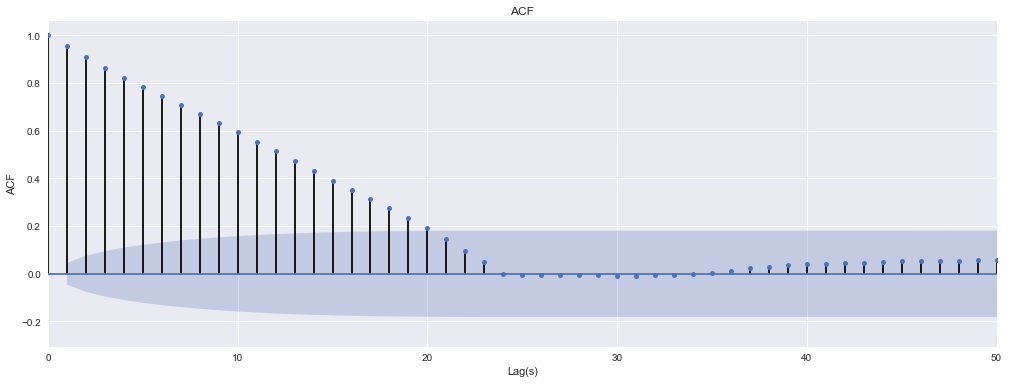

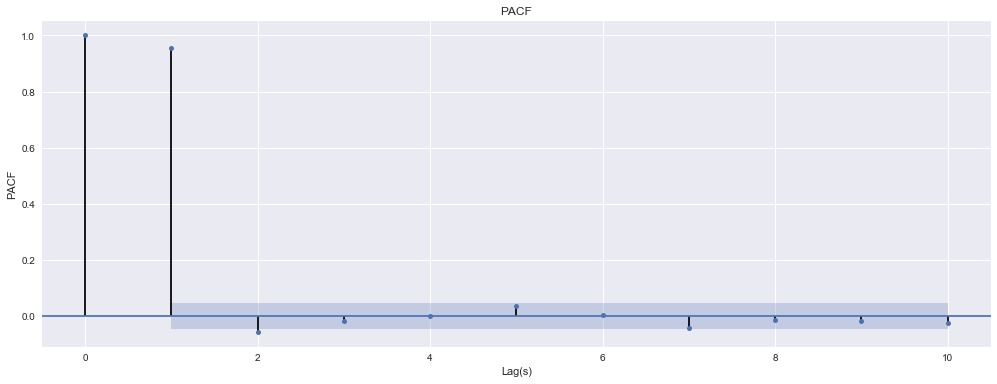

In [99]:
# Plotting ACF and PACF

# ACF
plot_acf(Y)
plt.title('ACF', loc='center')
plt.xlim((0, 50))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.show()

# PACF
plot_pacf(Y, lags=10)
plt.title('PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                    BTC   No. Observations:                 1330
Model:                     ARMA(1, 0)   Log Likelihood                2094.047
Method:                       css-mle   S.D. of innovations              0.050
Date:                Thu, 28 Jun 2018   AIC                          -4176.093
Time:                        02:38:40   BIC                          -4144.936
Sample:                    04-06-2018   HQIC                         -4164.416
                         - 06-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0119      0.023      0.526      0.599      -0.032       0.056
ETC            0.1510      0.022      7.014      0.000       0.109       0.193
LTC            0.6270      0.025     25.431      0.0

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


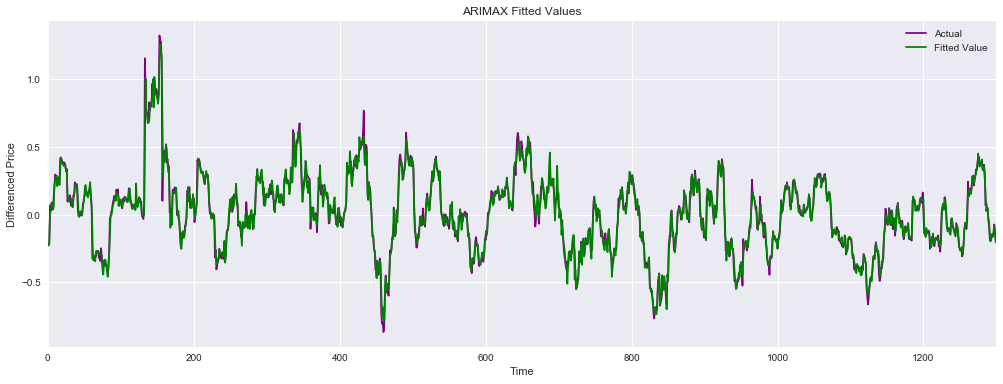

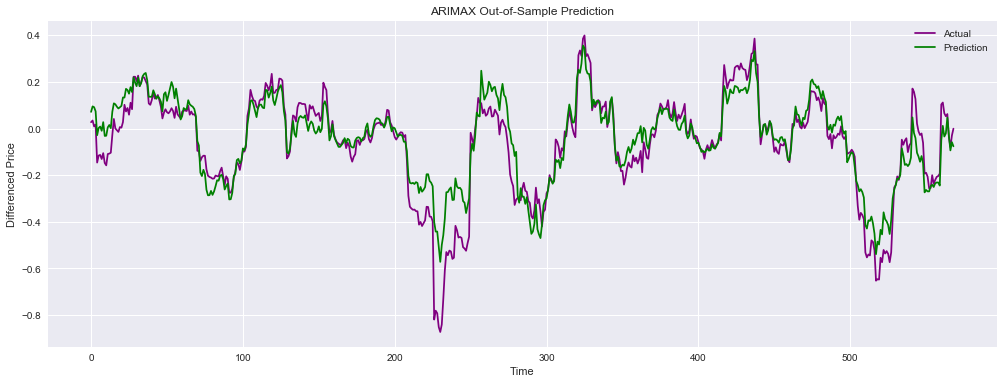

In [100]:
# ARIMAX

# Building AR 1 with exogeneous variables
arima_d = ARIMA.ARIMA(endog=Y_train, exog=X_train, order=[1,0,0])
arima_results_d = arima_d.fit()
print(arima_results_d.summary())

# Plotting the fitted values
plt.plot(np.arange(len(Y_train)), Y_train, color='purple', label='Actual')
plt.plot(np.arange(len(arima_results_d.fittedvalues)), arima_results_d.fittedvalues, color='green', label='Fitted Value')
plt.xlim((0, 1300))
plt.title('ARIMAX Fitted Values')
plt.xlabel('Time')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

# Out-of-sample prediction
arima_results_ofs_d = arima_results_d.predict(exog=X_test, start=X_test.index[0], end=X_test.index[-1])
plt.plot(np.arange(len(Y_test)), Y_test, color='purple', label='Actual')
plt.plot(np.arange(len(arima_results_ofs_d)), arima_results_ofs_d, color='green', label='Prediction')
#plt.xlim((0, 50))
plt.title('ARIMAX Out-of-Sample Prediction')
plt.xlabel('Time')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

In [101]:
# Metric

# Calculating mean squared error for steps 1-100
expected = Y_test[:99]
predictions = arima_results_ofs_d[:99]
mse = mean_squared_error(expected, predictions)
print('Mean Squared Error')
print('Steps 1-100: %f' % mse)

# Calculating mean squred error for steps 101-600
expected = Y_test[100:]
predictions = arima_results_ofs_d[100:]
mse = mean_squared_error(expected, predictions)
print('Steps 101-600: %f' % mse)

Mean Squared Error
Steps 1-100: 0.004182
Steps 101-600: 0.007804


# Getting ripe off scaling 

In [102]:
sig = ['ETC', 'LTC', 'QTUM']
def difference(dataset, interval=24):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Differencing the dataset
inter_d = 24
df_diff = pd.DataFrame(index=df.index)
for i in df.columns:
    data = difference(df[i], inter_d)
    data = pd.Series(np.append(np.repeat(np.nan, inter_d), data), index=df.index, name=i)
    df_diff = pd.concat([df_diff, data], ignore_index=False, axis=1)
    diff = df_diff.dropna()
X_sig = diff.loc[:,sig]
Y = diff.loc[:,'BTC']

In [103]:
X_train = X_sig[:1330]
X_test = X_sig[1330:]
X = X_sig
Y_train = pd.DataFrame(Y[:1330])
Y_test = pd.DataFrame(Y[1330:])
Y = pd.DataFrame(Y)

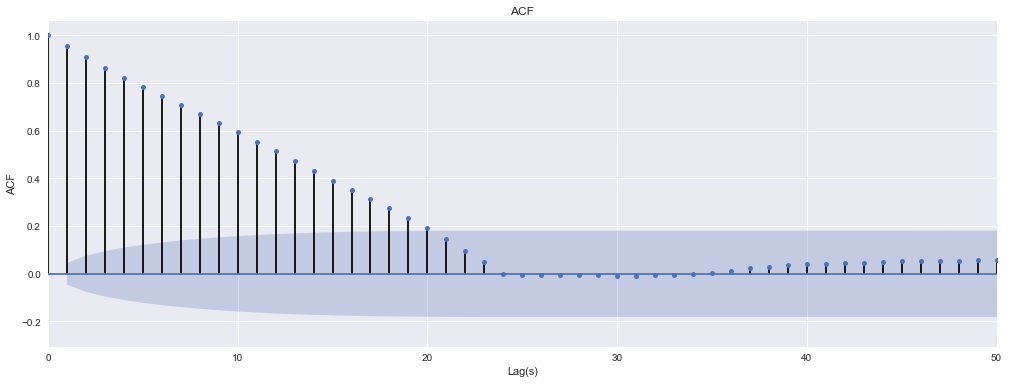

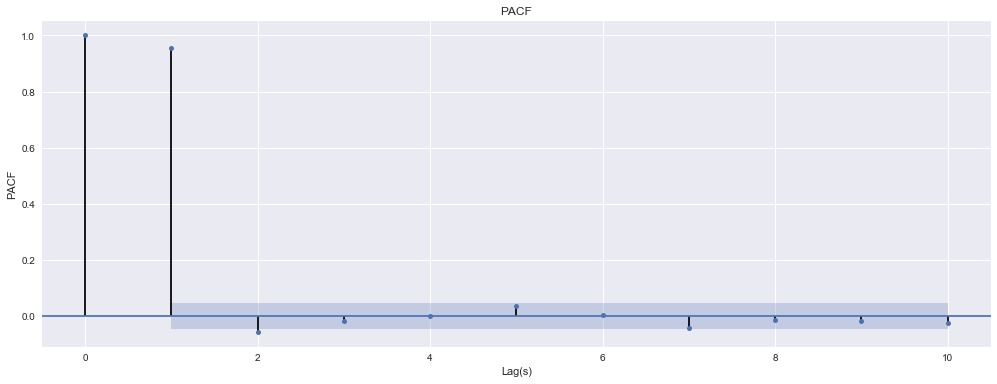

In [104]:
# Plotting ACF and PACF

# ACF
plot_acf(Y)
plt.title('ACF', loc='center')
plt.xlim((0, 50))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.show()

# PACF
plot_pacf(Y, lags=10)
plt.title('PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argumen

                              ARMA Model Results                              
Dep. Variable:                    BTC   No. Observations:                 1330
Model:                     ARMA(1, 0)   Log Likelihood               -7105.552
Method:                       css-mle   S.D. of innovations             50.540
Date:                Thu, 28 Jun 2018   AIC                          14223.103
Time:                        02:57:18   BIC                          14254.261
Sample:                    04-06-2018   HQIC                         14234.780
                         - 06-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0444     22.768      0.529      0.597     -32.579      56.668
ETC           51.5465      7.348      7.015      0.000      37.144      65.949
LTC           29.1342      1.146     25.430      0.0

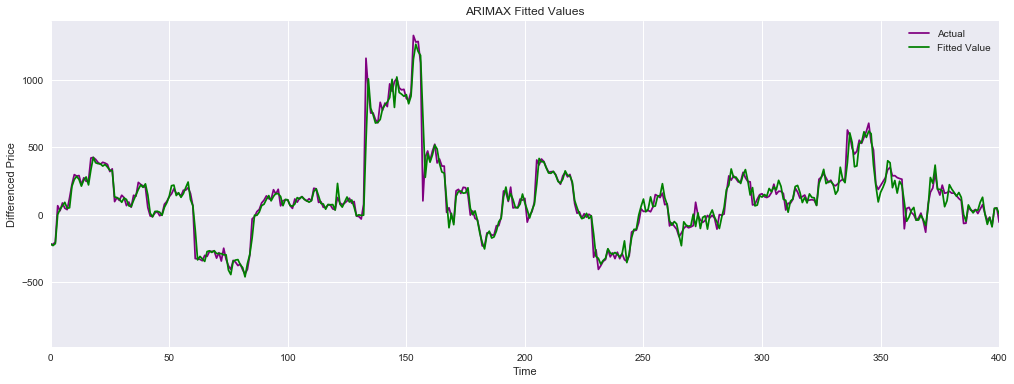

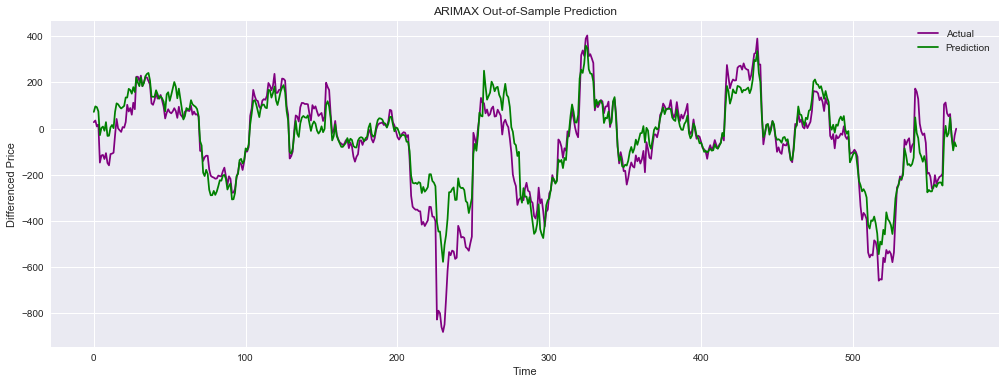

In [112]:
# ARIMAX

# Building AR 1 with exogeneous variables
arima_d = ARIMA.ARIMA(endog=Y_train, exog=X_train, order=[1,0,0])
arima_results_d = arima_d.fit()
print(arima_results_d.summary())

# Plotting the fitted values
plt.plot(np.arange(len(Y_train)), Y_train, color='purple', label='Actual')
plt.plot(np.arange(len(arima_results_d.fittedvalues)), arima_results_d.fittedvalues, color='green', label='Fitted Value')
plt.xlim((0, 400))
plt.title('ARIMAX Fitted Values')
plt.xlabel('Time')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

# Out-of-sample prediction
arima_results_ofs_d = arima_results_d.predict(exog=X_test, start=X_test.index[0], end=X_test.index[-1])
plt.plot(np.arange(len(Y_test)), Y_test, color='purple', label='Actual')
plt.plot(np.arange(len(arima_results_ofs_d)), arima_results_ofs_d, color='green', label='Prediction')
#plt.xlim((0, 50))
plt.title('ARIMAX Out-of-Sample Prediction')
plt.xlabel('Time')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

In [106]:
# Metric

# Calculating mean squared error for steps 1-100
expected = Y_test[:99]
predictions = arima_results_ofs_d[:99]
mse = mean_squared_error(expected, predictions)
print('Mean Squared Error')
print('Steps 1-100: %f' % mse)

# Calculating mean squred error for steps 101-600
expected = Y_test[100:]
predictions = arima_results_ofs_d[100:]
mse = mean_squared_error(expected, predictions)
print('Steps 101-600: %f' % mse)

Mean Squared Error
Steps 1-100: 4262.211347
Steps 101-600: 7952.207612
